In [1]:
import torch
import nn

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model1 = nn.Model('resnet18', 200)
model2 = nn.Model('dresnet18', 200)
model2 = nn.Model('dresnet182', 200)
model3 = nn.Model('psaresnet18', 200)
# model4 = nn.Model('psaresnet18', 200)
model5 = nn.Model('psdresnet18', 200)
model5 = nn.Model('psdresnet182', 200)
model3 = nn.Model('psadresnet18', 200)
model5 = nn.Model('psadresnet182', 200)

# model6 = nn.Model('psddresnet182', 200)
# model1.count_parameters()
# model1.model = model1.model
# print()
# model2.count_parameters()
# model2.model = model2.model

Success to initialize resnet18 model
Total trainable parameters: 1,453,800
Success to initialize dresnet18 model
Total trainable parameters: 1,431,664
Success to initialize psaresnet18 model
Total trainable parameters: 1,703,528
Success to initialize psadresnet18 model
Total trainable parameters: 1,681,392
Success to initialize psdresnet18 model
Total trainable parameters: 1,721,264


In [ ]:
pasdresnet182
psadresnet182

In [3]:
a = torch.zeros(1, 3, 64, 64).cuda()

In [4]:
model2.model = model2.model.cuda()

In [6]:
model2.model(a).shape

torch.Size([1, 200])

In [3]:
import torch.nn as nn
import torch

In [13]:
c = nn.Conv2d(10, 20, 1, 1, groups=1, bias=False)
a = torch.zeros((1, 10, 20, 20))

In [16]:
c(a).permute(0, 2, 3, 1).contiguous().is_contiguous()

True

In [ ]:
# dw31_0.85 사용해서  yolo size 확인하자

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = 'trained_models'
models = os.listdir(path)
stats = {name:{'recall':[], 'time':[], 'params':[]} for name in set([model[:-2] for model in models])}

In [3]:
for model in models:
    with open(f'{path}/{model}/model.info', 'r') as f:
        text = f.read()

    for p, paragraph in enumerate(text.split('\n\n')):
        for line in paragraph.split('\n'):
            if ':' in line:
                k, v = line.split(':')
                k, v = k.strip(' '), v.strip(' ')
                if p == 0:
                    if k == 'model_name':
                        model_name = v
                    elif k == 'params':
                        stats[model_name]['params'] += [int(v)]
                
                elif p == 1:
                    pass

                elif p == 2:
                    if k == 'process_time':
                        stats[model_name]['time'] += [float(v)]
                    elif k == 'recall':
                        stats[model_name]['recall'] += [float(v)]


In [4]:
m_stats = {k:{kk:np.mean(sorted(vv, reverse=True)[:]) for kk, vv in v.items()}for k, v in stats.items()}
m_stats

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'psddresnet18': {'recall': 0.4827, 'time': 0.0036001, 'params': 1670832.0},
 'dresnet18': {'recall': 0.4678, 'time': 0.00263701, 'params': 1434040.0},
 'psdresnet18': {'recall': 0.4763, 'time': 0.00301258, 'params': 1690592.0},
 'psdresnet182': {'recall': 0.478, 'time': 0.00296801, 'params': 1703048.0},
 'psddresnet182': {'recall': nan, 'time': nan, 'params': 1752440.0},
 'psadresnet182': {'recall': 0.4669, 'time': 0.00341126, 'params': 1752920.0},
 'dresnet182': {'recall': 0.4616, 'time': 0.00248244, 'params': 1503192.0},
 'psadresnet18': {'recall': 0.4836, 'time': 0.00362619, 'params': 1683768.0}}

In [5]:
def draw_bar(names_list, key='recall'):
    name_list = []
    x_list = []

    w = 0.35
    for i, names in enumerate(names_list):
        for j, name in enumerate(names):
            x = i + w * (j+0.5-len(names)/2)
            plt.bar(x, m_stats[name][key], w)
            name_list += [name[:-5]]
            x_list += [x]

    # plt.legend(ncols=2)
    plt.ylabel(key)
    # plt.xticks([i for i in range(len(names_list))], names_list)
    plt.xticks(x_list, name_list)
    if key == 'recall':
        plt.ylim(0.45, 0.5)
    elif key == 'time':
        plt.ylim(0.002, 0.004)
    elif key == 'params':
        plt.ylim(1440000, 1800000)
    plt.show()

In [10]:
model_names = [
               # ['resnet18', 'dresnet18'], 
               # ['psaresnet18', 'psdresnet18'],
               # ['psadresnet18', 'psddresnet18'],
               ['dresnet18', 'psdresnet18', 'psadresnet18', 'psddresnet18'],
               ['dresnet182', 'psdresnet182', 'psadresnet182', 'psddresnet182']
               # ['resnet18', 'psaresnet18', 'psdresnet182', 'psddresnet182']
              ]

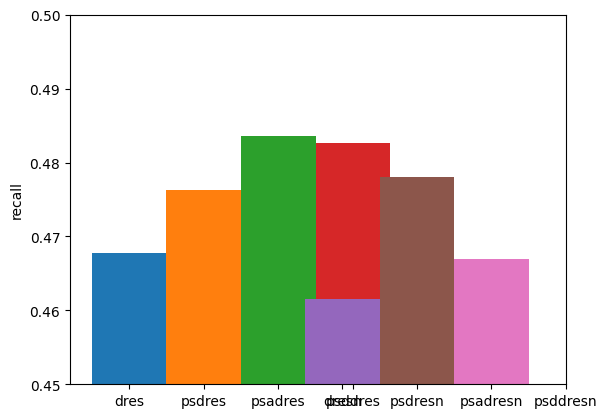

In [11]:
draw_bar(model_names, key='recall')

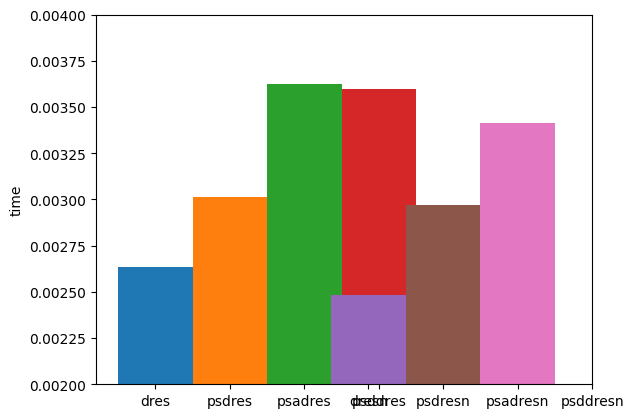

In [12]:
draw_bar(model_names, key='time')

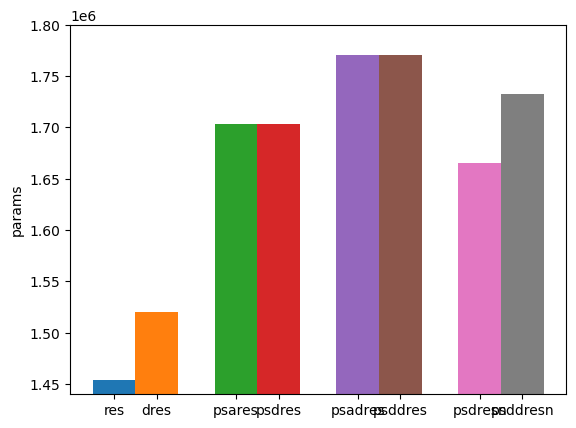

In [21]:
draw_bar(model_names, key='params')

In [ ]:
# psd는 그대로, dresnet은 dw_kernel_size를 3으로 바꿔서 해보자
# dw을 지우고 dcn의 projection 전 출력을 같은 크기의 1x1conv로 곱해서 modulate해보자
# 이거는 별론거 같고 차라리 dcn 밖에서 element-wise multiplication해보자

In [39]:
import data
import numpy as np
import torch

In [17]:
class ARGS:
    def __init__(self):
        self.data = 'tiny-imagenet'
        self.imgsz = 64
        self.batch_size = 4
args = ARGS()

In [18]:
train_loader, eval_loader, test_loader, nc = data.get_dataloader(args,
                                                                     split='all')

dataset/tiny-imagenet-200 already exists
Success to load tiny-imagenet all dataset


In [19]:
x, y = next(iter(train_loader))

In [31]:
np.argmax(y[0].numpy()), np.max(y[0].numpy()), np.min(y[0].numpy())

(22, 0.9502499999999999, 0.00025)

In [32]:
class Soft_Label():
    def __init__(self, p, nc):
        self.p = p/nc
        self.v = 1 - p + self.p
        self.nc = nc

    def __call__(self, label):
        soft_label = np.zeros([self.nc]) + self.p
        soft_label[label] = self.v
        return soft_label

In [33]:
soft_label = Soft_Label(0.1, 200)

In [34]:
np.max(soft_label(0))

0.9005

In [62]:
a = np.zeros([1,200])
a[0,0]=1

In [63]:
s = torch.nn.Softmax(dim=1)

In [64]:
s(torch.tensor(a))

tensor([[0.0135, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
         0.0050, 0.0050, 0.0